This notebook provides examples to go along with the [textbook](http://manipulation.csail.mit.edu/robot.html).  I recommend having both windows open, side-by-side!

Hand Notes from Russ: https://github.com/RussTedrake/manipulation/blob/master/robot/iiwa_with_allegro.ipynb

undefined. Obtain model points for ICP

undefined. Setup simulation environment: attach arm to hand, setup floating hand, painter

undefined. Find transform of floating hand through ICP

undefined. Get trajectory transforms using floating hand transform

undefined. execute painter based on trajectory

undefined. (Make sure trajectory slows down as it approaches the hand)

In [ ]:
from pydrake.all import FindResourceOrThrow, StartMeshcat

from manipulation import running_as_notebook
from manipulation.meshcat_utils import model_inspector

from IPython.display import HTML, SVG, display
import pydot

from scipy.spatial import KDTree
import numpy as np
from pydrake.all import (AddMultibodyPlantSceneGraph, DiagramBuilder,
                         FindResourceOrThrow, MeshcatVisualizer, Parser,
                         RigidTransform, RotationMatrix, StartMeshcat,
                         DepthImageToPointCloud, BaseField, MeshcatPointCloudVisualizer,
                         ConstantValueSource, Rgba, LeafSystem, PointCloud, PassThrough, PidController)

from manipulation.scenarios import (AddMultibodyTriad, AddRgbdSensor,
                                    MakeManipulationStation)
                
from pydrake.perception import Concatenate

from pydrake.all import (AbstractValue, AddMultibodyPlantSceneGraph, BaseField,
                         ConstantValueSource, DepthImageToPointCloud,
                         DiagramBuilder, FindResourceOrThrow,
                         MeshcatPointCloudVisualizer, MeshcatVisualizer,
                         MeshcatVisualizerParams, Parser, PointCloud,
                         RigidTransform, RollPitchYaw, RotationMatrix,
                         StartMeshcat, ConstantVectorSource, )

from pydrake.all import (
    AbstractValue, Adder, AddMultibodyPlantSceneGraph, BallRpyJoint, BaseField,
    Box, CameraInfo, Capsule, ClippingRange, CoulombFriction, Cylinder,
    Demultiplexer, DepthImageToPointCloud, DepthRange, DepthRenderCamera,
    DiagramBuilder, FindResourceOrThrow, GeometryInstance,
    InverseDynamicsController, LeafSystem, LoadModelDirectivesFromString,
    MakeMultibodyStateToWsgStateSystem, MakePhongIllustrationProperties,
    MakeRenderEngineVtk, ModelInstanceIndex, MultibodyPlant, Parser,
    PassThrough, PrismaticJoint, ProcessModelDirectives, RenderCameraCore,
    RenderEngineVtkParams, RevoluteJoint, Rgba, RgbdSensor, RigidTransform,
    RollPitchYaw, RotationMatrix, SchunkWsgPositionController, SpatialInertia,
    Sphere, StateInterpolatorWithDiscreteDerivative, UnitInertia)

from manipulation.utils import AddPackagePaths, FindResource
from manipulation import FindResource, running_as_notebook
from manipulation.scenarios import SetColor, AddIiwaDifferentialIK
import matplotlib.pyplot as plt
import mpld3
import numpy as np
import pydot
from IPython.display import HTML, display
from manipulation import running_as_notebook, FindResource
from manipulation.meshcat_utils import AddMeshcatTriad
from manipulation.scenarios import MakeManipulationStation, AddIiwa, AddWsg, AddRgbdSensors
from pydrake.all import (AddMultibodyPlantSceneGraph, AngleAxis, BasicVector,
                         ConstantVectorSource, DiagramBuilder,
                         FindResourceOrThrow, Integrator, JacobianWrtVariable,
                         LeafSystem, MeshcatVisualizer,
                         MeshcatVisualizerParams, MultibodyPlant,
                         MultibodyPositionToGeometryPose, Parser,
                         PiecewisePose, Quaternion, RigidTransform,
                         RollPitchYaw, RotationMatrix, SceneGraph, Simulator,
                         StartMeshcat, TrajectorySource, RevoluteJoint, JointSliders)


In [ ]:
# Start the visualizer.
meshcat = StartMeshcat()
fist_joint_angles = [0, 0, 0, 0, 0, 0, 0, 0, 1.61,1.41,1.53,0,1.44,1.6,1.39,0,1.61,1.71,1.16,0,1.61,1.71,1.16]


INFO:drake:Meshcat listening for connections at https://ab49ec77-8b85-4b68-8f2d-7b435787898b.deepnoteproject.com/7000/
Installing NginX server for MeshCat on Deepnote...


# Robot arms


The next two cells will give you a simple interface to move the joints around on a variety of robot arm models.

Have a favorite robot that I haven't included here?  If you send me a link to a properly licensed URDF or SDF description of the robot and it's mesh files, I'm happy to add it!  It's worth taking a look at the files quickly, to get a sense for how they work: [SDF](https://github.com/RobotLocomotion/drake/blob/master/manipulation/models/iiwa_description/sdf/iiwa14_no_collision.sdf), [URDF](https://github.com/RobotLocomotion/drake/blob/master/manipulation/models/iiwa_description/urdf/iiwa14_no_collision.urdf).

Note: The Jaco doesn't visualize properly in this renderer yet.  See drake issue [#13846](https://github.com/RobotLocomotion/drake/issues/13846).

In [ ]:
###PLEASE DONT DELETE THIS CONNECTS THE HAND AND ARM ILL CRY IF U DO
def setup_env(use_fist, new_p, new_R):
    meshcat.Delete()
    meshcat.DeleteAddedControls()
    builder = DiagramBuilder()

    # Adds both MultibodyPlant and the SceneGraph, and wires them together.
    plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=1e-5)
    parser = Parser(plant, scene_graph)
    # Note that we parse into both the plant and the scene_graph here.
    parser.AddModelFromFile(
            FindResourceOrThrow("drake/manipulation/models/iiwa_description/sdf/iiwa14_no_collision.sdf"))
    parser.AddModelFromFile(
            FindResourceOrThrow("drake/manipulation/models/allegro_hand_description/sdf/allegro_hand_description_right.sdf"))
    arm_frame = plant.GetFrameByName("iiwa_link_7")
    hand_frame = plant.GetFrameByName("hand_root")
    plant.AddJoint(RevoluteJoint(
            "wrist_joint", arm_frame, hand_frame,
            [0, -1, 0],  -np.pi, np.pi))
    plant.WeldFrames(plant.world_frame(), plant.GetFrameByName("iiwa_link_0"))

    # Floating Hand
    allegro_file = FindResourceOrThrow("drake/manipulation/models/allegro_hand_description/sdf/allegro_hand_description_right.sdf")
    hand = parser.AddModelFromFile(allegro_file, "float_hand")


    # Add a box for the camera in the environment.
    X_Camera = RigidTransform(
        RollPitchYaw(0, 0, 0).ToRotationMatrix().multiply(
            RollPitchYaw(-np.pi/2.0, 0, np.pi/2.0).ToRotationMatrix()),
        [-.1, 0, .9])
    camera_instance = parser.AddModelFromFile(FindResource("models/camera_box.sdf"))
    camera_frame = plant.GetFrameByName("base", camera_instance)    
    plant.WeldFrames(plant.world_frame(), camera_frame, X_Camera)
    AddMultibodyTriad(camera_frame, scene_graph, length=.1, radius=0.005)

    plant.Finalize()


    B_H = plant.GetBodyByName("hand_root", hand)

    inspector = scene_graph.model_inspector()
    for body_index in plant.GetBodyIndices(hand):
        SetColor(
            scene_graph, [0, .6, 0, .5], plant.get_source_id(), 
            inspector.GetGeometries(plant.GetBodyFrameIdOrThrow(body_index)))
            
    meshcat.SetProperty("/Background", "visible", False)

    # Adds the MeshcatVisualizer and wires it to the SceneGraph.
    visualizer = MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat)

    # Camera sensors
    camera = AddRgbdSensor(builder, scene_graph, X_PC=RigidTransform(),
                            parent_frame_id=plant.GetBodyFrameIdOrThrow(
                                camera_frame.body().index()))
    camera.set_name("rgbd_sensor")

    # Export the camera outputs
    builder.ExportOutput(camera.color_image_output_port(), "color_image")
    builder.ExportOutput(camera.depth_image_32F_output_port(), "depth_image")

    # Add a system to convert the camera output into a point cloud
    to_point_cloud = builder.AddSystem(
        DepthImageToPointCloud(camera_info=camera.depth_camera_info(),
                                fields=BaseField.kXYZs | BaseField.kRGBs))
    builder.Connect(camera.depth_image_32F_output_port(),
                    to_point_cloud.depth_image_input_port())
    builder.Connect(camera.color_image_output_port(),
                    to_point_cloud.color_image_input_port())

    # Send the point cloud to meshcat for visualization, too.
    point_cloud_visualizer = builder.AddSystem(
        MeshcatPointCloudVisualizer(meshcat, "cloud"))
    builder.Connect(to_point_cloud.point_cloud_output_port(),
                    point_cloud_visualizer.cloud_input_port())
    camera_pose = builder.AddSystem(
        ConstantValueSource(AbstractValue.Make(X_Camera)))
    builder.Connect(camera_pose.get_output_port(),
                    point_cloud_visualizer.pose_input_port())

    # Export the point cloud output.
    builder.ExportOutput(to_point_cloud.point_cloud_output_port(),
                            "point_cloud")

    sliders = builder.AddSystem(
            JointSliders(meshcat,
                            plant))

    diagram = builder.Build()
    context = diagram.CreateDefaultContext()
    plant_context = plant.GetMyContextFromRoot(context)

    if use_fist:
        plant.SetPositions(plant_context, hand, fist_joint_angles)

    X_WH = RigidTransform(new_R, new_p)
    plant.SetFreeBodyPose(plant_context, B_H, X_WH)
    return diagram, context, X_Camera


In [ ]:
def show_rgbd_plots(diagram, context):
    diagram.Publish(context)
    color_image = diagram.GetOutputPort("color_image").Eval(context)
    depth_image = diagram.GetOutputPort("depth_image").Eval(context)

    # Plot the two images.
    plt.subplot(121)
    plt.imshow(color_image.data)
    plt.title('Color image')
    plt.subplot(122)
    plt.imshow(np.squeeze(depth_image.data))
    plt.title('Depth image')
    #mpld3.display()
    plt.show()


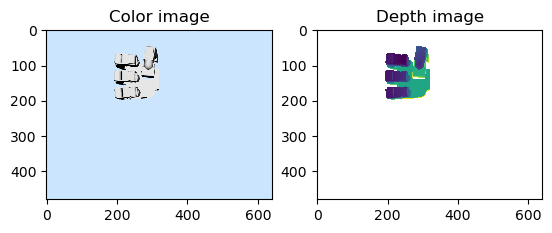

In [ ]:
new_p = [-.7, 0, 1]
new_R = RotationMatrix.MakeXRotation(np.pi/2)
diagram, context, X_Camera = setup_env(True, new_p, new_R) # True for fist, False for hand
diagram.Publish(context)
show_rgbd_plots(diagram, context)

### Generating Known Correspondences

The code below was used to setup a camera and get the point cloud points for either a hand or a fist

In [ ]:
'''
sides: 
0: back
1: front
2: right
3: left
4: top
5: bottom
'''
def get_base_cloud(use_fist, side):
    meshcat.Delete()
    meshcat.DeleteAddedControls()
    builder = DiagramBuilder()
    new_p = [0, 0, 0]

    # Adds both MultibodyPlant and the SceneGraph, and wires them together.
    plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=1e-5)
    parser = Parser(plant, scene_graph)

    # Floating Hand
    allegro_file = FindResourceOrThrow("drake/manipulation/models/allegro_hand_description/sdf/allegro_hand_description_right.sdf")
    hand = parser.AddModelFromFile(allegro_file, "float_hand")

    # Add a box for the camera in the environment.
    X_Camera = RigidTransform(
        RollPitchYaw(0, 0, 0).ToRotationMatrix().multiply(
            RollPitchYaw(-np.pi/2.0, 0, np.pi/2.0).ToRotationMatrix()),
        [.8, 0, 0])
    if use_fist:
        X_Camera = RigidTransform(
        RollPitchYaw(0, 0, 0).ToRotationMatrix().multiply(
            RollPitchYaw(-np.pi/2.0, 0, np.pi/2.0).ToRotationMatrix()),
            [.8, 0, 0])
    if side == 10:
        new_R = RotationMatrix().MakeYRotation(np.pi/2)
        X = RigidTransform(new_R.MakeYRotation(-np.pi/2), new_p)
        X_Camera = RigidTransform(
        RollPitchYaw(0, 0, 0).ToRotationMatrix().multiply(
            RollPitchYaw(-np.pi/2.0, 0, 3.3*np.pi/5.0).ToRotationMatrix()),
            [.8, .5, 0])
    elif side == 11:
        new_R = RotationMatrix().MakeYRotation(np.pi/2)
        X = RigidTransform(new_R.MakeYRotation(-np.pi/2), new_p)
        X_Camera = RigidTransform(
        RollPitchYaw(0, 0, 0).ToRotationMatrix().multiply(
            RollPitchYaw(-np.pi/2.0, 0, 1.7*np.pi/5.0).ToRotationMatrix()),
            [.8, -.5, 0])
    # if use_fist:
    #     X_Camera = RigidTransform(
    #         RollPitchYaw(0, 0, 0).ToRotationMatrix().multiply(
    #             RollPitchYaw(np.pi, 0, np.pi/2.0).ToRotationMatrix()),
    #         [0, 0, .6])

    camera_instance = parser.AddModelFromFile(FindResource("models/camera_box.sdf"))
    camera_frame = plant.GetFrameByName("base", camera_instance)    
    plant.WeldFrames(plant.world_frame(), camera_frame, X_Camera)
    AddMultibodyTriad(camera_frame, scene_graph, length=.1, radius=0.005)

    plant.Finalize()
            
    meshcat.SetProperty("/Background", "visible", False)

    # Adds the MeshcatVisualizer and wires it to the SceneGraph.
    visualizer = MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat)

    # Camera sensors
    camera = AddRgbdSensor(builder, scene_graph, X_PC=RigidTransform(),
                            parent_frame_id=plant.GetBodyFrameIdOrThrow(
                                camera_frame.body().index()))
    camera.set_name("rgbd_sensor")

    # Export the camera outputs
    builder.ExportOutput(camera.color_image_output_port(), "color_image")
    builder.ExportOutput(camera.depth_image_32F_output_port(), "depth_image")

    # Add a system to convert the camera output into a point cloud
    to_point_cloud = builder.AddSystem(
        DepthImageToPointCloud(camera_info=camera.depth_camera_info(),
                                fields=BaseField.kXYZs | BaseField.kRGBs))
    builder.Connect(camera.depth_image_32F_output_port(),
                    to_point_cloud.depth_image_input_port())
    builder.Connect(camera.color_image_output_port(),
                    to_point_cloud.color_image_input_port())

    # Send the point cloud to meshcat for visualization, too.
    point_cloud_visualizer = builder.AddSystem(
        MeshcatPointCloudVisualizer(meshcat, "cloud"))
    builder.Connect(to_point_cloud.point_cloud_output_port(),
                    point_cloud_visualizer.cloud_input_port())
    camera_pose = builder.AddSystem(
        ConstantValueSource(AbstractValue.Make(X_Camera)))
    builder.Connect(camera_pose.get_output_port(),
                    point_cloud_visualizer.pose_input_port())

    # Export the point cloud output.
    builder.ExportOutput(to_point_cloud.point_cloud_output_port(),
                            "point_cloud")


    diagram = builder.Build()
    context = diagram.CreateDefaultContext()
    plant_context = plant.GetMyContextFromRoot(context)
    temp_R = RotationMatrix()
    if use_fist:
        plant.SetPositions(plant_context, hand, fist_joint_angles)
        # temp_R = RotationMatrix().MakeYRotation(np.pi/2.0)
    B_H = plant.GetBodyByName("hand_root", hand)
    #front side
    if side == 0:
        new_R = temp_R
        X = RigidTransform(new_R, new_p)
    # back side
    elif side == 1:
        new_R = temp_R.MakeZRotation(np.pi)
        X = RigidTransform(new_R.MakeZRotation(-np.pi), new_p)
    # right side
    elif side == 2:
        new_R = temp_R.MakeZRotation(np.pi/2)
        X = RigidTransform(new_R.MakeZRotation(-np.pi/2), new_p)
    # left side
    elif side == 3:
        new_R = temp_R.MakeZRotation(-np.pi/2)
        X = RigidTransform(new_R.MakeZRotation(np.pi/2), new_p)
    # top
    elif side == 4:
        new_R = temp_R.MakeYRotation(np.pi/2)
        X = RigidTransform(new_R.MakeYRotation(-np.pi/2), new_p)
    # bottom
    elif side == 5:
        new_R = temp_R.MakeYRotation(-np.pi/2)
        X = RigidTransform(new_R.MakeYRotation(np.pi/2), new_p)
    elif side == 6:
        new_R = temp_R.MakeZRotation(np.pi/6)
        X = RigidTransform(new_R.MakeZRotation(-np.pi/6), new_p)
    elif side == 7:
        new_R = temp_R.MakeZRotation(-np.pi/6)
        X = RigidTransform(new_R.MakeZRotation(np.pi/6), new_p)
    elif side == 8:
        new_R = temp_R.MakeYRotation(np.pi/6)
        X = RigidTransform(new_R.MakeYRotation(-np.pi/6), new_p)
    elif side == 9:
        new_R = temp_R.MakeYRotation(-np.pi/6)
        X = RigidTransform(new_R.MakeYRotation(np.pi/6), new_p)
    X_WH = RigidTransform(new_R, new_p)
    plant.SetFreeBodyPose(plant_context, B_H, X_WH)

    diagram.Publish(context)
    # depth_image = diagram.GetOutputPort("depth_image").Eval(context)

    pc = PointCloud(diagram.GetOutputPort("point_cloud").Eval(context))
    # # print(pc)
    # meshcat.SetObject("pcl_scene", pc)

    pc_arr = pc.xyzs()
    res = pc_arr[:, np.all(pc_arr != np.inf, axis=0)]
    return X@X_Camera@res
# pc_1 = get_base_cloud(True, 10)

In [ ]:
# Generate high-five known point cloud
xyzs_front = get_base_cloud(False, 0)
pc_1 = get_base_cloud(False, 6)
pc_2 = get_base_cloud(False, 7)
# Concat all point cloud points
used_pc = xyzs_front
used_pc = np.append(used_pc, pc_1, axis=1)
used_pc = np.append(used_pc, pc_2, axis=1)
# Filter out values that do not belong to the hand
used_pc_hi_five = used_pc[:, np.all(used_pc != np.inf, axis=0)]

# xyzs_front = get_base_cloud(False, 1)
# xyzs_right = get_base_cloud(False, 2)
# xyzs_left = get_base_cloud(False, 3)
# xyzs_top = get_base_cloud(False, 4)
# xyzs_bottom = get_base_cloud(False, 5)
# pc_3 = get_base_cloud(False, 8)
# pc_4 = get_base_cloud(False, 9)
# used_pc = np.append(xyzs_front, xyzs_back, axis=1)
# used_pc = np.append(used_pc, xyzs_right, axis=1)
# used_pc = np.append(used_pc, xyzs_left, axis=1)
# used_pc = np.append(used_pc, xyzs_top, axis=1)
# used_pc = np.append(used_pc, xyzs_bottom, axis=1)
# used_pc = np.append(used_pc, pc_3, axis=1)
# used_pc = np.append(used_pc, pc_4, axis=1)

In [ ]:
# Generate fist-bump known point cloud
# xyzs_back = get_base_cloud(True, 0)
# xyzs_front = get_base_cloud(True, 1)
# xyzs_right = get_base_cloud(True, 2)
# xyzs_left = get_base_cloud(True, 3)
xyzs_top = get_base_cloud(True, 4)
# xyzs_bottom = get_base_cloud(True, 5)
pc_1 = get_base_cloud(True, 10)
pc_2 = get_base_cloud(True, 11)
# Concat all point cloud points
used_pc = xyzs_top
# used_pc = np.append(xyzs_front, xyzs_back, axis=1)
# used_pc = np.append(used_pc, xyzs_right, axis=1)
# used_pc = np.append(used_pc, xyzs_left, axis=1)
# used_pc = np.append(used_pc, xyzs_top, axis=1)
# used_pc = np.append(used_pc, xyzs_bottom, axis=1)
used_pc = np.append(used_pc, pc_1, axis=1)
used_pc = np.append(used_pc, pc_2, axis=1)
# Filter out values that do not belong to the hand
used_pc_fist2 = used_pc[:, np.all(used_pc != np.inf, axis=0)]
used_pc_fist1 = RigidTransform(RotationMatrix().MakeYRotation(np.pi/2.0), [0,0,0])@used_pc_fist2

In [ ]:
bound1 = used_pc_fist1[:, (used_pc_fist1[0,:] > .11)]
bound2 = used_pc_fist1[:, (used_pc_fist1[1,:] > .06)]
bound3 = used_pc_fist1[:, (used_pc_fist1[2,:] < .01)]
# bound4 = used_pc_fist1[:, (used_pc_fist1[1,:] > .04)]
t = np.append(bound1, bound2, axis=1)
t = np.append(t, bound3, axis=1)
# used_pc_fist = np.append(t, bound4, axis=1)
used_pc_fist = t
used_pc_fist1 = None
used_pc_fist2 = None
used_pc = None
xyzs_top = None
pc_1 = None
pc_2 = None
xyzs_front = None

In [ ]:
'''
USED TO VISUALIZE THE POINT CLOUD
'''
points = used_pc_hi_five

cloud = PointCloud(points.shape[1])
cloud.mutable_xyzs()[:] = points

meshcat.Delete()
meshcat.SetProperty("/Background",'visible', False)
meshcat.SetObject("red_bunny", cloud, point_size=0.001, rgba=Rgba(1.0, 0, 0))
meshcat.SetTransform("red_bunny", RigidTransform())

### ICP

In [ ]:
###PLEASE DONT DELETE THIS CONNECTS THE HAND AND ARM ILL CRY IF U DO
def test_icp_env(use_fist, new_p, new_R):
    meshcat.Delete()
    meshcat.DeleteAddedControls()
    builder = DiagramBuilder()

    # Adds both MultibodyPlant and the SceneGraph, and wires them together.
    plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=1e-5)
    parser = Parser(plant, scene_graph)

    # Floating Hand
    allegro_file = FindResourceOrThrow("drake/manipulation/models/allegro_hand_description/sdf/allegro_hand_description_right.sdf")
    hand = parser.AddModelFromFile(allegro_file, "float_hand")


    # Add a box for the camera in the environment.
    X_Camera = RigidTransform(
        RollPitchYaw(0, 0, 0).ToRotationMatrix().multiply(
            RollPitchYaw(-np.pi/2.0, 0, np.pi/2.0).ToRotationMatrix()),
        [-.1, 0, .9])
    camera_instance = parser.AddModelFromFile(FindResource("models/camera_box.sdf"))
    camera_frame = plant.GetFrameByName("base", camera_instance)    
    plant.WeldFrames(plant.world_frame(), camera_frame, X_Camera)
    AddMultibodyTriad(camera_frame, scene_graph, length=.1, radius=0.005)

    # Add a box for the camera in the environment.
    X_Camera_1 = RigidTransform(
        RollPitchYaw(0, 0, 0).ToRotationMatrix().multiply(
            RollPitchYaw(-np.pi/2, 0, np.pi).ToRotationMatrix()),
        [0, .6, 0])
    camera_instance1 = parser.AddModelFromFile(FindResource("models/camera_box.sdf"), "cam1")
    camera_frame1 = plant.GetFrameByName("base", camera_instance1)    
    plant.WeldFrames(plant.world_frame(), camera_frame1, X_Camera_1)
    AddMultibodyTriad(camera_frame1, scene_graph, length=.1, radius=0.005)

    plant.Finalize()


    B_H = plant.GetBodyByName("hand_root", hand)
            
    meshcat.SetProperty("/Background", "visible", False)

    # Adds the MeshcatVisualizer and wires it to the SceneGraph.
    visualizer = MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat)

    # Camera sensors
    camera = AddRgbdSensor(builder, scene_graph, X_PC=RigidTransform(),
                            parent_frame_id=plant.GetBodyFrameIdOrThrow(
                                camera_frame.body().index()))
    camera.set_name("rgbd_sensor")

    camera1 = AddRgbdSensor(builder, scene_graph, X_PC=RigidTransform(),
                            parent_frame_id=plant.GetBodyFrameIdOrThrow(
                                camera_frame1.body().index()))
    camera1.set_name("rgbd_sensor1")

    # Export the camera outputs
    builder.ExportOutput(camera.color_image_output_port(), "color_image")
    builder.ExportOutput(camera.depth_image_32F_output_port(), "depth_image")

    # Add a system to convert the camera output into a point cloud
    to_point_cloud = builder.AddSystem(
        DepthImageToPointCloud(camera_info=camera.depth_camera_info(),
                                fields=BaseField.kXYZs | BaseField.kRGBs))
    builder.Connect(camera.depth_image_32F_output_port(),
                    to_point_cloud.depth_image_input_port())
    builder.Connect(camera.color_image_output_port(),
                    to_point_cloud.color_image_input_port())

    # Send the point cloud to meshcat for visualization, too.
    point_cloud_visualizer = builder.AddSystem(
        MeshcatPointCloudVisualizer(meshcat, "cloud"))
    builder.Connect(to_point_cloud.point_cloud_output_port(),
                    point_cloud_visualizer.cloud_input_port())
    camera_pose = builder.AddSystem(
        ConstantValueSource(AbstractValue.Make(X_Camera)))
    builder.Connect(camera_pose.get_output_port(),
                    point_cloud_visualizer.pose_input_port())

    # Export the point cloud output.
    builder.ExportOutput(to_point_cloud.point_cloud_output_port(),
                            "point_cloud")


    # Export the camera outputs
    builder.ExportOutput(camera1.color_image_output_port(), "color_image1")
    builder.ExportOutput(camera1.depth_image_32F_output_port(), "depth_image1")

    # Add a system to convert the camera output into a point cloud
    to_point_cloud1 = builder.AddSystem(
        DepthImageToPointCloud(camera_info=camera1.depth_camera_info(),
                                fields=BaseField.kXYZs | BaseField.kRGBs))
    builder.Connect(camera1.depth_image_32F_output_port(),
                    to_point_cloud1.depth_image_input_port())
    builder.Connect(camera1.color_image_output_port(),
                    to_point_cloud1.color_image_input_port())

    # Send the point cloud to meshcat for visualization, too.
    point_cloud_visualizer1 = builder.AddSystem(
        MeshcatPointCloudVisualizer(meshcat, "cloud1"))
    builder.Connect(to_point_cloud1.point_cloud_output_port(),
                    point_cloud_visualizer1.cloud_input_port())
    camera_pose1 = builder.AddSystem(
        ConstantValueSource(AbstractValue.Make(X_Camera_1)))
    builder.Connect(camera_pose1.get_output_port(),
                    point_cloud_visualizer1.pose_input_port())

    # Export the point cloud output.
    builder.ExportOutput(to_point_cloud1.point_cloud_output_port(),
                            "point_cloud1")


    diagram = builder.Build()
    context = diagram.CreateDefaultContext()
    plant_context = plant.GetMyContextFromRoot(context)

    if use_fist:
        plant.SetPositions(plant_context, hand, fist_joint_angles)

    X_WH = RigidTransform(new_R, new_p)
    plant.SetFreeBodyPose(plant_context, B_H, X_WH)
    return diagram, context, X_Camera, X_Camera_1


In [ ]:
def least_squares_transform(scene, model) -> RigidTransform:
    '''
    Calculates the least-squares best-fit transform that maps corresponding
    points scene to model.
    Args:
      scene: 3xN numpy array of corresponding points
      model: 3xM numpy array of corresponding points
    Returns:
      X_BA: A RigidTransform object that maps point_cloud_A on to point_cloud_B 
            such that
                        X_BA.multiply(model) ~= scene,
    '''
    X_BA = RigidTransform()
    ##################
    # your code here
    ##################
    model_t = model.T
    scene_t = scene.T
    model_center = model_t.mean(axis=0)
    scene_center = scene_t.mean(axis=0)
    model_err = model_t - model_center
    scene_err = scene_t - scene_center
    W = np.matmul(scene_err.T, model_err)
    U, Sigma, Vt = np.linalg.svd(W)
    R = np.matmul(U, Vt)
    if np.linalg.det(R) < 0:
       Vt[-1, :] *= -1
       R = np.matmul(U, Vt)
    p = scene_center - np.matmul(R, model_center)

    return RigidTransform(RotationMatrix(R), p)

In [ ]:
def nearest_neighbors(scene, model):
    '''
    Find the nearest (Euclidean) neighbor in model for each
    point in scene
    Args:
        scene: 3xN numpy array of points
        model: 3xM numpy array of points
    Returns:
        distances: (N, ) numpy array of Euclidean distances from each point in
            scene to its nearest neighbor in model.
        indices: (N, ) numpy array of the indices in model of each
            scene point's nearest neighbor - these are the c_i's
    '''
    distances = np.empty(scene.shape[1], dtype=float)
    indices = np.empty(scene.shape[1], dtype=int)
    
    kdtree = KDTree(model.T)
    for i in range(scene.shape[1]):
        distances[i], indices[i] = kdtree.query(scene[:,i], 1)

    return distances, indices

In [ ]:
def icp(scene, model, max_iterations=20, tolerance=1e-3, model_name="red_bunny"):
    '''
    Perform ICP to return the correct relative transform between two set of points.
    Args:
        scene: 3xN numpy array of points
        model: 3xM numpy array of points
        max_iterations: max amount of iterations the algorithm can perform.
        tolerance: tolerance before the algorithm converges.
    Returns:
      X_BA: A RigidTransform object that maps point_cloud_A on to point_cloud_B 
            such that
                        X_BA.multiply(model) ~= scene,
      mean_error: Mean of all pairwise distances. 
      num_iters: Number of iterations it took the ICP to converge. 
    '''
    X_BA = RigidTransform()

    mean_error = 0
    num_iters = 0
    prev_error = 0
    
    while True:
        num_iters += 1  
          
        # your code here
        ##################
        distances, indices = nearest_neighbors(scene, X_BA@model)
        mean_error = np.mean(distances) # Modify to add mean error.
        model_new = model[:, indices]
        X_BA = least_squares_transform(scene, model_new)
        ##################
        # print(mean_error)

        if abs(mean_error - prev_error) < tolerance or num_iters >= max_iterations:
            break
        prev_error = mean_error

        meshcat.SetTransform(model_name, X_BA)

    return X_BA, mean_error, num_iters

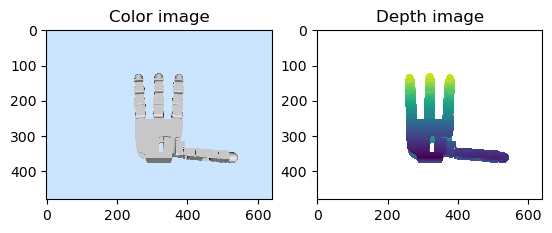

In [ ]:
import time
import math
'''
For hi-five set filter=5, iterations 100, tolerance, 1e-6 for best performance
fist bump tbd
'''
filter = 5
use_fist = False # need to connect to boolean above?
if use_fist: 
    # new_p = [-.55, 0, .85]
    # new_R = RotationMatrix()
    new_p = [-.55, 0, .85]
    new_R = RotationMatrix().MakeYRotation(np.pi/2)
else:
    new_p = [-.55, 0, .8]
    new_R = RotationMatrix().MakeYRotation(-np.pi/6)
    # xtra = RigidTransform(RotationMatrix().MakeZRotation(np.pi/6.0), [0, 0, 0])


diagram, context, X_Camera = setup_env(use_fist, new_p, new_R)

# if use_fist:
model_pc_fist = used_pc_fist[:, ::filter]
model_pc_fist = model_pc_fist + np.array([X_Camera.translation()]).T
# model_pc_fist = RigidTransform(RotationMatrix().MakeYRotation(np.pi/2.0), [0, 0, 0])@model_pc_fist

# else:
model_pc_hand = used_pc_hi_five[:, ::filter]
model_pc_hand = model_pc_hand + np.array([X_Camera.translation()]).T

cloud_hand = PointCloud(model_pc_hand.shape[1])
cloud_hand.mutable_xyzs()[:] = model_pc_hand

cloud_fist = PointCloud(model_pc_fist.shape[1])
cloud_fist.mutable_xyzs()[:] = model_pc_fist


meshcat.SetProperty("/Background",'visible', False)
# meshcat.SetProperty("/Cameras/default/rotated/<object>","zoom", 10.5)


diagram.Publish(context)
show_rgbd_plots(diagram, context)

In [ ]:
start = time.time()
pc = PointCloud(diagram.GetOutputPort("point_cloud").Eval(context))
pc_arr = pc.xyzs()
clean_pc = pc_arr[:, np.all(pc_arr != np.inf, axis=0)]
clean_pc = X_Camera@clean_pc[:, ::filter]
desired_pt_model_hand = [model_pc_hand[0][1000], model_pc_hand[1][1000], model_pc_hand[2][1000]]
fist_pt = 200
desired_pt_model_fist = [model_pc_fist[0][fist_pt], model_pc_fist[1][fist_pt], model_pc_fist[2][fist_pt]]

desired_pose_model_fist = RigidTransform(RotationMatrix(), desired_pt_model_fist)
desired_pose_model_hand = RigidTransform(RotationMatrix(), desired_pt_model_hand)


meshcat.SetObject("fist_model", cloud_fist, point_size=0.01, rgba=Rgba(1.0, 0, 0))
meshcat.SetTransform("fist_model", RigidTransform())
fist_s = time.time()
X_ModelScene_fist, error_fist, _ = icp(clean_pc, model_pc_fist, max_iterations=70, tolerance=1e-5, model_name="fist_model")
print(time.time() - fist_s)

meshcat.SetObject("hand_model", cloud_hand, point_size=0.01, rgba=Rgba(0, 1.0, 0))
meshcat.SetTransform("hand_model", RigidTransform())
hand_s = time.time()
X_ModelScene_hand, error_hand, _ = icp(clean_pc, model_pc_hand, max_iterations=70, tolerance=1e-5, model_name="hand_model")
print(time.time() - hand_s)
if error_fist > error_hand:
    X_ModelScene = X_ModelScene_hand
    extra = [.02, .04, -.07]
    desired_pose_model = RigidTransform(desired_pose_model_hand.rotation(), extra + desired_pose_model_hand.translation())
    is_hand_fist = False
    print("Using hand")
else:
    X_ModelScene = X_ModelScene_fist
    extra = [0, 0, -.001]
    desired_pose_model = RigidTransform(desired_pose_model_fist.rotation(), extra + desired_pose_model_fist.translation())
    is_hand_fist = True
    print("Using fist")
AddMeshcatTriad(meshcat, "painter/",
                        length=0.15, radius=0.006, X_PT=X_ModelScene.multiply(desired_pose_model))
desired_pose = X_ModelScene.multiply(desired_pose_model)
print(time.time() - start)
print(error_fist)
print(error_hand)

scene_points = PointCloud(clean_pc.shape[1])
scene_points.mutable_xyzs()[:] = clean_pc
# desired_pose_world = X_Camera.multiply(desired_pose)


1.8306117057800293
4.955683708190918
Using hand
6.798243284225464
0.022236853145034114
0.0015684087182429387


## Trajectory Planning/IK

In [ ]:
model_directives_fist = """
directives:
- add_model:
    name: iiwa
    file: package://drake/manipulation/models/iiwa_description/iiwa7/iiwa7_no_collision.sdf
    # file: package://hand/iiwa.sdf
    default_joint_positions:
        iiwa_joint_1: [0]
        iiwa_joint_2: [0]
        iiwa_joint_3: [0]
        iiwa_joint_4: [0]
        iiwa_joint_5: [0]
        iiwa_joint_6: [0]
        iiwa_joint_7: [0]
- add_weld:
    parent: world
    child: iiwa::iiwa_link_0
- add_model:
    name: floating_hand
    # file: package://hand/allegro_hand.sdf
    # file: package://drake/manipulation/models/wsg_50_description/sdf/schunk_wsg_50.sdf
    file: package://drake/manipulation/models/allegro_hand_description/sdf/allegro_hand_description_right.sdf
- add_weld:
    parent: iiwa::iiwa_link_7
    child: floating_hand::hand_root
    X_PC:
        translation: [0, 0, 0.03]
        rotation: !Rpy { deg: [0, 0, 180]}
- add_model:
    name: other_hand
    file: package://drake/manipulation/models/allegro_hand_description/sdf/allegro_hand_description_right.sdf
    default_joint_positions:
        joint_0: [0]
        joint_1: [1.61]
        joint_2: [1.41]
        joint_3: [1.53]
        joint_4: [0]
        joint_5: [1.44]
        joint_6: [1.6]
        joint_7: [1.39]
        joint_8: [0]
        joint_9: [1.61]
        joint_10: [1.71]
        joint_11: [1.16]
        joint_12: [0]
        joint_13: [1.61]
        joint_14: [1.71]
        joint_15: [1.16]
- add_weld:
    parent: world
    child: other_hand::hand_root
    X_PC:
        translation: [-.55, 0, .85]
        rotation: !Rpy { deg: [0, 90, 0]}

"""


In [ ]:
model_directives_hand = """
directives:
- add_model:
    name: iiwa
    file: package://drake/manipulation/models/iiwa_description/iiwa7/iiwa7_no_collision.sdf
    # file: package://hand/iiwa.sdf
    default_joint_positions:
        iiwa_joint_1: [0]
        iiwa_joint_2: [0]
        iiwa_joint_3: [0]
        iiwa_joint_4: [0]
        iiwa_joint_5: [0]
        iiwa_joint_6: [0]
        iiwa_joint_7: [0]
- add_weld:
    parent: world
    child: iiwa::iiwa_link_0
- add_model:
    name: floating_hand
    file: package://hand/allegro_hand.sdf
    # file: package://drake/manipulation/models/wsg_50_description/sdf/schunk_wsg_50.sdf
    # file: package://drake/manipulation/models/allegro_hand_description/sdf/allegro_hand_description_right.sdf
- add_weld:
    parent: iiwa::iiwa_link_7
    child: floating_hand::hand_root
    X_PC:
        translation: [0, 0, 0.03]
        rotation: !Rpy { deg: [0, 0, 180]}
- add_model:
    name: other_hand
    file: package://hand/allegro_hand.sdf
    # file: package://hand/iiwa.sdf
    # file: package://drake/manipulation/models/allegro_hand_description/sdf/allegro_hand_description_right.sdf
    # default_free_body_pose
- add_weld:
    parent: world
    child: other_hand::hand_root
    X_PC:
        translation: [-0.55, 0.0, 0.75]
        rotation: !Rpy { deg: [0, 30, 180]}

"""

In [ ]:
def MyMakeManipulationStation(model_directives=None,
                            filename=None,
                            time_step=0.0001,
                            iiwa_prefix="iiwa",
                            wsg_prefix="wsg",
                            camera_prefix="camera",
                            prefinalize_callback=None,
                            package_xmls=[],
                            is_fist=False):
    """
    Creates a manipulation station system, which is a sub-diagram containing:
      - A MultibodyPlant with populated via the Parser from the
        `model_directives` argument AND the `filename` argument.
      - A SceneGraph
      - For each model instance starting with `iiwa_prefix`, we add an
        additional iiwa controller system
      - For each model instance starting with `wsg_prefix`, we add an
        additional schunk controller system
      - For each body starting with `camera_prefix`, we add a RgbdSensor
    Args:
        builder: a DiagramBuilder
        model_directives: a string containing any model directives to be parsed
        filename: a string containing the name of an sdf, urdf, mujoco xml, or
        model directives yaml file.
        time_step: the standard MultibodyPlant time step.
        iiwa_prefix: Any model instances starting with `iiwa_prefix` will get
        an inverse dynamics controller, etc attached
        wsg_prefix: Any model instance starting with `wsg_prefix` will get a
        schunk controller
        camera_prefix: Any bodies in the plant (created during the
        plant_setup_callback) starting with this prefix will get a camera
        attached.
        prefinalize_callback: A function, setup(plant), that will be called
        with the multibody plant before calling finalize.  This can be useful
        for e.g. adding additional bodies/models to the simulation.
        package_xmls: A list of filenames to be passed to
        PackageMap.AddPackageXml().  This is useful if you need to add more
        models to your path (e.g. from your current working directory).
    """
    builder = DiagramBuilder()

    # Add (only) the iiwa, WSG, and cameras to the scene.
    plant, scene_graph = AddMultibodyPlantSceneGraph(builder,
                                                     time_step=time_step)
    parser = Parser(plant)


    for p in package_xmls:
        parser.package_map().AddPackageXml(p)
    AddPackagePaths(parser)
    if model_directives:
        directives = LoadModelDirectivesFromString(model_directives)
        ProcessModelDirectives(directives, parser)
    if filename:
        parser.AddAllModelsFromFile(filename)
    if prefinalize_callback:
        prefinalize_callback(plant)
    # allegro_file = FindResourceOrThrow("drake/manipulation/models/allegro_hand_description/sdf/allegro_hand_description_right.sdf")
    # allegro_file = FindResourceOrThrow("allegro_hand.sdf")
    # hand = parser.AddModelFromFile("allegro_hand.sdf", "other_hand")
    plant.Finalize()

    for i in range(plant.num_model_instances()):
        model_instance = ModelInstanceIndex(i)
        model_instance_name = plant.GetModelInstanceName(model_instance)

        if model_instance_name.startswith(iiwa_prefix):
            num_iiwa_positions = plant.num_positions(model_instance)

            # I need a PassThrough system so that I can export the input port.
            iiwa_position = builder.AddSystem(PassThrough(num_iiwa_positions))
            builder.ExportInput(iiwa_position.get_input_port(),
                                model_instance_name + "_position")
            builder.ExportOutput(iiwa_position.get_output_port(),
                                 model_instance_name + "_position_commanded")

            # Export the iiwa "state" outputs.
            demux = builder.AddSystem(
                Demultiplexer(2 * num_iiwa_positions, num_iiwa_positions))
            builder.Connect(plant.get_state_output_port(model_instance),
                            demux.get_input_port())
            builder.ExportOutput(demux.get_output_port(0),
                                 model_instance_name + "_position_measured")
            builder.ExportOutput(demux.get_output_port(1),
                                 model_instance_name + "_velocity_estimated")
            builder.ExportOutput(plant.get_state_output_port(model_instance),
                                 model_instance_name + "_state_estimated")

            # Make the plant for the iiwa controller to use.
            controller_plant = MultibodyPlant(time_step=time_step)
            # TODO: Add the correct IIWA model (introspected from MBP)
            if plant.num_positions(model_instance) == 3:
                controller_iiwa = AddPlanarIiwa(controller_plant)
            else:
                controller_iiwa = AddIiwa(controller_plant)
            AddWsg(controller_plant, controller_iiwa, welded=True)
            controller_plant.Finalize()

            # Add the iiwa controller
            iiwa_controller = builder.AddSystem(
                InverseDynamicsController(controller_plant,
                                          kp=[100] * num_iiwa_positions,
                                          ki=[1] * num_iiwa_positions,
                                          kd=[20] * num_iiwa_positions,
                                          has_reference_acceleration=False))
            iiwa_controller.set_name(model_instance_name + "_controller")
            builder.Connect(plant.get_state_output_port(model_instance),
                            iiwa_controller.get_input_port_estimated_state())

            # Add in the feed-forward torque
            adder = builder.AddSystem(Adder(2, num_iiwa_positions))
            builder.Connect(iiwa_controller.get_output_port_control(),
                            adder.get_input_port(0))
            # Use a PassThrough to make the port optional (it will provide zero
            # values if not connected).
            torque_passthrough = builder.AddSystem(
                PassThrough([0] * num_iiwa_positions))
            builder.Connect(torque_passthrough.get_output_port(),
                            adder.get_input_port(1))
            builder.ExportInput(torque_passthrough.get_input_port(),
                                model_instance_name + "_feedforward_torque")
            builder.Connect(adder.get_output_port(),
                            plant.get_actuation_input_port(model_instance))

            # Add discrete derivative to command velocities.
            desired_state_from_position = builder.AddSystem(
                StateInterpolatorWithDiscreteDerivative(
                    num_iiwa_positions,
                    time_step,
                    suppress_initial_transient=True))
            desired_state_from_position.set_name(
                model_instance_name + "_desired_state_from_position")
            builder.Connect(desired_state_from_position.get_output_port(),
                            iiwa_controller.get_input_port_desired_state())
            builder.Connect(iiwa_position.get_output_port(),
                            desired_state_from_position.get_input_port())

            # Export commanded torques.
            builder.ExportOutput(adder.get_output_port(),
                                 model_instance_name + "_torque_commanded")
            builder.ExportOutput(adder.get_output_port(),
                                 model_instance_name + "_torque_measured")

            builder.ExportOutput(
                plant.get_generalized_contact_forces_output_port(
                    model_instance), model_instance_name + "_torque_external")

        elif model_instance_name.startswith(wsg_prefix):

            # Wsg controller.
            wsg_controller = builder.AddSystem(SchunkWsgPositionController())
            wsg_controller.set_name(model_instance_name + "_controller")
            builder.Connect(wsg_controller.get_generalized_force_output_port(),
                            plant.get_actuation_input_port(model_instance))
            builder.Connect(plant.get_state_output_port(model_instance),
                            wsg_controller.get_state_input_port())
            builder.ExportInput(
                wsg_controller.get_desired_position_input_port(),
                model_instance_name + "_position")
            builder.ExportInput(wsg_controller.get_force_limit_input_port(),
                                model_instance_name + "_force_limit")
            wsg_mbp_state_to_wsg_state = builder.AddSystem(
                MakeMultibodyStateToWsgStateSystem())
            builder.Connect(plant.get_state_output_port(model_instance),
                            wsg_mbp_state_to_wsg_state.get_input_port())
            builder.ExportOutput(wsg_mbp_state_to_wsg_state.get_output_port(),
                                 model_instance_name + "_state_measured")
            builder.ExportOutput(wsg_controller.get_grip_force_output_port(),
                                 model_instance_name + "_force_measured")
        elif model_instance_name == "other_hand" and is_fist:
            model = plant.GetModelInstanceByName("other_hand")
            if is_fist:
                # vector = np.zeros(16)
                vector = np.array([0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05])
            # hand_ = builder.AddSystem(ConstantVectorSource(test))
            hand_ = builder.AddSystem(ConstantVectorSource(vector))
            # print(plant.get_actuation_input_port(model).GetFullDescription())
            builder.Connect(hand_.get_output_port(), plant.get_actuation_input_port(model))
        elif model_instance_name == "floating_hand" and is_fist:
            model = plant.GetModelInstanceByName("floating_hand")
            # hand_controller = builder.AddSystem(InverseDynamicsController(plant, np.array(200.0), np.array(0.0), np.array(5.0), False))
            # hand_controller.set_name("floating_hand_controller")
            # builder.Connect(hand_controller.get_output_port_control(), plant.get_actuation_input_port(model))
            # builder.ExportInput(hand_controller.get_input_port_desired_state(), "floating_hand_position")
            if is_fist:
                # vector = np.zeros(16)
                vector = np.array([0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05])
            else:
                # vector = 0.0001 * np.ones(16)
                vector = np.zeros(16)
            # hand_ = builder.AddSystem(ConstantVectorSource(test))
            hand_ = builder.AddSystem(ConstantVectorSource(vector))
            # print(plant.get_actuation_input_port(model).GetFullDescription())
            builder.Connect(hand_.get_output_port(), plant.get_actuation_input_port(model))


    # Cameras.
    AddRgbdSensors(builder,
                   plant,
                   scene_graph,
                   model_instance_prefix=camera_prefix)

    # Export "cheat" ports.
    builder.ExportOutput(scene_graph.get_query_output_port(), "query_object")
    builder.ExportOutput(plant.get_contact_results_output_port(),
                         "contact_results")
    builder.ExportOutput(plant.get_state_output_port(),
                         "plant_continuous_state")
    builder.ExportOutput(plant.get_body_poses_output_port(), "body_poses")

    diagram = builder.Build()


    # context = diagram.CreateDefaultContext()
    # plant_context = plant.GetMyContextFromRoot(context)


    # X_WH = RigidTransform(new_R, new_p)
    # plant.SetFreeBodyPose(plant_context, hand, X_WH)
    # plant_context = plant.GetMyContextFromRoot(context)


    diagram.set_name("ManipulationStation")
    return diagram

In [ ]:
class PoseTrajectorySource(LeafSystem):
    def __init__(self, pose_trajectory):
        LeafSystem.__init__(self)
        self._pose_trajectory = pose_trajectory
        self.DeclareAbstractOutputPort(
            "pose", lambda: AbstractValue.Make(RigidTransform()),
            self.CalcPose)

    def CalcPose(self, context, output):
        output.set_value(self._pose_trajectory.GetPose(context.get_time()))

class IIWA_Painter():
    def __init__(self, traj=None, timestep=.0001, is_fist=False, use_fist=False, desired_pose=None):
        self.use_fist = use_fist
        self.joint_positions = [0, 0, 0, 0, 0, 0, 0, 0, 1.61,1.41,1.53,0,1.44,1.6,1.39,0,1.61,1.71,1.16,0,1.61,1.71,1.16]
        self.desired_pose = desired_pose

        meshcat.Delete()
        builder = DiagramBuilder()
        # set up the system of manipulation station
        if is_fist:
        # self.station = MyMakeManipulationStation(model_directives, package_xmls=["./package.xml"], time_step=timestep)
            self.station = MyMakeManipulationStation(model_directives_fist, package_xmls=["./package.xml"], is_fist=True, time_step=timestep)
        else:
            self.station = MyMakeManipulationStation(model_directives_hand, package_xmls=["./package.xml"], is_fist=False, time_step=timestep)
        
        builder.AddSystem(self.station)
        self.plant = self.station.GetSubsystemByName("plant")
        
        # context = self.plant.CreateDefaultContext()
        # context_ = self.station.GetMyContextFromRoot(context)
        # hand = self.plant.GetModelInstanceByName("floating_hand")
        # self.plant.SetPositions(context=context, model_instance=hand, q=np.zeros(16))
        # for i in range(16):
        #     finger = self.plant.GetJointByName(f'joint_{i}', model_instance=hand)
        #     finger.Lock(context)
        print("num ", self.plant.num_actuators())
        # builder.AddSystem(self.station)
        controller_plant = self.station.GetSubsystemByName(
            "iiwa_controller").get_multibody_plant_for_control()

        # optionally add trajectory source
        if traj is not None:
            traj_source = builder.AddSystem(PoseTrajectorySource(traj))
            self.controller = AddIiwaDifferentialIK(
                builder,
                controller_plant,
                frame=controller_plant.GetFrameByName("body"))
            builder.Connect(traj_source.get_output_port(),
                            self.controller.get_input_port(0))
            builder.Connect(self.station.GetOutputPort("iiwa_state_estimated"),
                            self.controller.GetInputPort("robot_state"))

            builder.Connect(self.controller.get_output_port(),
                            self.station.GetInputPort("iiwa_position"))

        params = MeshcatVisualizerParams()
        params.delete_on_initialization_event = False
        self.visualizer = MeshcatVisualizer.AddToBuilder(
            builder, self.station.GetOutputPort("query_object"), meshcat, params)

        # wsg_position = builder.AddSystem(ConstantVectorSource([0.1]))
        # builder.Connect(wsg_position.get_output_port(),
        #                 self.station.GetInputPort("wsg_position"))
        self.diagram = builder.Build()
        wsg = self.plant.GetModelInstanceByName("floating_hand")
        self.gripper_frame = self.plant.GetFrameByName('hand_root', wsg)
        # self.gripper_grame = wsg.GetFrameByName('hand_root')
        self.world_frame = self.plant.world_frame()

        context = self.CreateDefaultContext()
        hand = self.plant.GetModelInstanceByName("floating_hand")
        # self.plant.SetPositions(context=context, model_instance=hand, q=np.zeros(16))
        # for i in range(16):
        #     finger = self.plant.GetJointByName(f'joint_{i}', model_instance=hand)
        #     finger.Lock(context)
        # self.plant.SetPositions(self.plant.CreateDefaultContext(), hand, self.joint_angles)
        self.diagram.Publish(context)

    def visualize_frame(self, name, X_WF, length=0.15, radius=0.006):
        """
        visualize imaginary frame that are not attached to existing bodies
        
        Input: 
            name: the name of the frame (str)
            X_WF: a RigidTransform to from frame F to world.
        
        Frames whose names already exist will be overwritten by the new frame
        """
        AddMeshcatTriad(meshcat, "painter/" + name,
                        length=length, radius=radius, X_PT=X_WF)

    def CreateDefaultContext(self):
        context = self.diagram.CreateDefaultContext()
        # hand = self.plant.GetModelInstanceByName("floating_hand")
        # finger = self.plant.GetJointByName("joint_1", model_instance=hand)
        # context = self.CreateDefaultContext()
        # finger.Lock(context)
        plant_context = self.diagram.GetMutableSubsystemContext(
            self.plant, context)
        station_context = self.diagram.GetMutableSubsystemContext(
            self.station, context)
        # meshcat.SetObject("other_model", scene_points, point_size=0.01, rgba=Rgba(1.0, 0, 0))
        # meshcat.SetTransform("other_model", RigidTransform())

        # _context = self.plant.GetMyContextFromRoot(context)


        # B_H = self.plant.GetModelInstanceByName("other_hand")
        # if self.desired_pose:
        #     print(type(_context))
        #     print(B_H)
        #     print(self.desired_pose)
        #     self.plant.SetFreeBodyPose(_context, B_H, self.desired_pose)

        # float_hand = self.plant.GetModelInstanceByName("other_hand")
        # print(float_hand)
        # print(float_hand.num_positions())
        # if self.use_fist:
        #     joint_angles = [0, 0, 0, 0, 0, 0, 0, 0, 1.61,1.41,1.53,0,1.44,1.6,1.39,0,1.61,1.71,1.16,0,1.61,1.71,1.16]
        #     self.plant.SetPositions(plant_context, float_hand, .05*np.ones(16))
        # else:
        #     self.plant.SetPositions(plant_context, float_hand, np.zeros(16))
        # provide initial states
        q0 = np.array([0, 1, 0, 2, 0, 1, 0])
        # set the joint positions of the kuka arm
        iiwa = self.plant.GetModelInstanceByName("iiwa")
        self.plant.SetPositions(plant_context, iiwa, q0)
        self.plant.SetVelocities(plant_context, iiwa, np.zeros(7))
        # wrist = self.plant.GetJointByName("iiwa_joint_6")
        # wrist.Lock(plant_context)
        wsg = self.plant.GetModelInstanceByName("floating_hand")
        # self.plant.SetPositions(plant_context, wsg, np.zeros(16))
        # self.plant.SetVelocities(plant_context, wsg, np.zeros(16))        

        if hasattr(self, 'integrator'):
            self.integrator.set_integral_value(
                self.integrator.GetMyMutableContextFromRoot(context), q0)

        return context


    def get_X_WG(self, context=None):

        if not context:
            context = self.CreateDefaultContext()
        plant_context = self.plant.GetMyMutableContextFromRoot(context)
        X_WG = self.plant.CalcRelativeTransform(
                    plant_context,
                    frame_A=self.world_frame,
                    frame_B=self.gripper_frame)
        return X_WG

    def paint(self, sim_duration=20.0):
        context = self.CreateDefaultContext()
        simulator = Simulator(self.diagram, context)
        simulator.set_target_realtime_rate(1.0)
        plant_context = self.plant.GetMyMutableContextFromRoot(context)
        station_context = self.station.GetMyMutableContextFromRoot(context)

        # q0 = self.plant.GetPositions(plant_context, self.plant.GetModelInstanceByName('floating_hand'))
        # print(q0)
        # self.station.GetInputPort('floating_hand_position').FixValue(station_context, q0)

        duration = sim_duration if running_as_notebook else 0.01
        start = time.time()
        simulator.AdvanceTo(duration)
        print(time.time() - start)


In [ ]:
def compose_key_frames(num_frames, X_WorldDesired, X_WorldGripper_init, is_fist=False):
    """    
    returns: a list of RigidTransforms
    """
    ## this is an template, replace your code below
    key_frame_poses_in_world = []
    R = X_WorldGripper_init.rotation()
    R_ = X_WorldDesired.rotation().MakeZRotation(np.pi)
    x = RigidTransform(RotationMatrix().MakeZRotation(np.pi/2.0), np.zeros(3))
    y = RigidTransform(RotationMatrix().MakeXRotation(np.pi/2.0), np.zeros(3))
    z = RigidTransform(RotationMatrix().MakeZRotation(np.pi/2.0), np.zeros(3))
    start = np.array(X_WorldGripper_init.translation())
    if is_fist:
        offset = [.055, 0, 0]
    else:
        offset = [-.03,0,-.075]
    end = np.array(X_WorldDesired.translation()) + offset
    # mid = X_WorldDesired@RigidTransform(R_, [.2, 0, 0])
    # painter.visualize_frame('mid', mid, length=0.05)
    increment = (end - start) / num_frames
    print(start)
    for k in range(num_frames):
        p = start + k * increment
        if is_fist:
            key_frame_poses_in_world.append(RigidTransform(X_WorldDesired.rotation(), p)@z)
        else:
            key_frame_poses_in_world.append(RigidTransform(X_WorldDesired.rotation(), p)@x@y)
    if is_fist:
        key_frame_poses_in_world.append(RigidTransform(X_WorldDesired.rotation(), end)@z)
    else:
        key_frame_poses_in_world.append(RigidTransform(X_WorldDesired.rotation(), end)@x@y)
    return key_frame_poses_in_world

In [ ]:
painter = IIWA_Painter(is_fist=is_hand_fist)
X_WG1 = painter.get_X_WG()
painter.visualize_frame('gripper_current1', X_WG1)
painter.visualize_frame('desired', desired_pose)

num  7


In [ ]:
# meshcat.Delete() # comment out if want to see trajectory and hand and fist
# check key frames instead of interpolated trajectory
def visualize_key_frames(frame_poses):
    for i, pose in enumerate(frame_poses):
        painter.visualize_frame('frame_{}1'.format(i), pose, length=0.05)
        
key_frame_poses = compose_key_frames(10, desired_pose, X_WG1, is_hand_fist)   
visualize_key_frames(key_frame_poses)

[9.43410525e-17 1.79227941e-16 8.82701542e-01]


In [ ]:
times = np.linspace(0, 8, 10+1)
traj = PiecewisePose.MakeLinear(times, key_frame_poses)
painter = IIWA_Painter(traj, timestep=.00025, is_fist=is_hand_fist, desired_pose=key_frame_poses[-1])
painter.visualize_frame("final_pos", key_frame_poses[-1])
painter.paint(sim_duration=8)

num  7
9.727041006088257


In [ ]:
# test = MakeManipulationStation(model_directives=model_directives)
# SVG(pydot.graph_from_dot_data(painter.diagram.GetGraphvizString())[0].create_svg())

This code block is just for testing two cameras

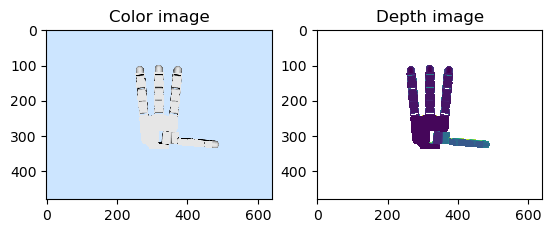

(3, 4487)
(3, 7903)


In [ ]:
new_p = [-.7, 0, .8]
new_R = RotationMatrix()#.MakeZRotation(np.pi/6.0).MakeYRotation(-np.pi/6.0).MakeXRotation(np.pi/4.0)
use_fist = False

diagram, context, X_Camera, X_Camera_1 = test_icp_env(use_fist, new_p, new_R)

if use_fist:
    model_pc = used_pc_fist[:, ::5]
else:
    model_pc = used_pc_hi_five[:, ::5]

model_pc = model_pc + np.array([X_Camera.translation()]).T
cloud = PointCloud(model_pc.shape[1])
cloud.mutable_xyzs()[:] = model_pc

pointcloud_model = model_pc

meshcat.SetProperty("/Background",'visible', False)
meshcat.SetProperty("/Cameras/default/rotated/<object>","zoom", 10.5)
meshcat.SetObject("red_bunny", cloud, point_size=0.001, rgba=Rgba(1.0, 0, 0))
meshcat.SetTransform("red_bunny", RigidTransform())


diagram.Publish(context)
show_rgbd_plots(diagram, context)
pc = PointCloud(diagram.GetOutputPort("point_cloud").Eval(context))
pc_arr = pc.xyzs()
clean_pc = pc_arr[:, np.all(pc_arr != np.inf, axis=0)]
clean_pc = X_Camera@clean_pc[:, ::5]

pc1 = PointCloud(diagram.GetOutputPort("point_cloud1").Eval(context))
pc_arr1 = pc1.xyzs()
clean_pc1 = pc_arr1[:, np.all(pc_arr1 != np.inf, axis=0)]
clean_pc1 = X_Camera_1@clean_pc1[:, ::1]

# clean_pc = np.append(clean_pc, clean_pc1, axis=1)
# model_pc = model_pc[:, :clean_pc.shape[1]]
# ratio = model_pc.shape[1]//clean_pc.shape[1]
# model_pc = model_pc[:, ::ratio]
# model_pc = model_pc[:, :clean_pc.shape[1]]
print(clean_pc.shape)
print(model_pc.shape)
res = icp(clean_pc, model_pc, max_iterations=60, tolerance=1e-5)

In [ ]:
AddMeshcatTriad(meshcat, "estimated_pose", length=0.1,
                    radius=0.01, X_PT=res[0])
meshcat.SetTransform("red_bunny", res[0])
AddMeshcatTriad(meshcat, "actual_pose", length=0.1,
                    radius=0.01, X_PT=RigidTransform(new_R, new_p))
found_cloud = PointCloud(clean_pc.shape[1])
found_cloud.mutable_xyzs()[:] = clean_pc
meshcat.SetObject("found_cloud", found_cloud, point_size=0.01, rgba=Rgba(1.0, 0, 0))

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=ab49ec77-8b85-4b68-8f2d-7b435787898b' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>